In [ ]:
#@title
##################################################
## Author: Yuqing Qiao
## Copyright: Copyright 2023, tensorflow infrared object detection training
## License: MIT
## Version: 1.0 @ 0323
## Mmaintainer: Yuqing Qiao
## Email: qyqfiles@hotmail.com
## Status: under development
##################################################

# Converter that converts yolo annotation file to passcal voc

In [ ]:
#@title
# @credits: https://github.com/JPM-Tech/Object-Detection/blob/main/Scripts/converters/convert-yolo-to-xml.py

import os
import re
from PIL import Image
from random import shuffle
from glob import glob
import math
import shutil


class FileHelper:
  def __init__(self):
    self.rootPath = os.getcwd()
    self.curPath = self.rootPath

  def is_number(self,n):
    try:
      float(n)
      return True
    except ValueError:
      return False

  def chdir(self,folder_abs_path):
    self.curPath = folder_abs_path
    os.chdir(self.curPath)
  
  def getAbsPath(self,folder_path):
    return os.path.join(self.rootPath,folder_path)

  # shuffle and split 80%, 10%, 10% for the train, validation and test
  def shuffle_and_split(self,mov_dir,file_extension, target_dir):
    train_ratio = 0.8
    val_ratio = 0.1

    image_path = os.path.join(mov_dir,r"*."+file_extension)

    files = glob(image_path)
    shuffle(files) # shuffle files

    # create train, test, val folder in target_dir
    if not os.path.exists(self.getAbsPath(target_dir)):
      os.mkdir(target_dir)
    
    for dataset_dir in ["train","test","val"]:
      if not os.path.exists(os.path.join(target_dir,dataset_dir)):
        os.mkdir(os.path.join(target_dir,dataset_dir))

    total_files= len(files)
    train_split_num = math.floor((total_files)*train_ratio)
    val_split_num = math.floor((total_files)*val_ratio)
    
    for i,file in enumerate(files):
      base,extension = os.path.splitext(os.path.basename(file))
      old_filename_jpg = file
      old_filename_xml = os.path.join(mov_dir,"XML",base+".xml")
      
      # split train dataset
      if i < train_split_num:  
        new_filename_jpg = os.path.join(target_dir,"train",base+extension)
        new_filename_xml = os.path.join(target_dir,"train",base+".xml")
        
        shutil.copy(old_filename_jpg,new_filename_jpg) #copy *.jpg to /train/*.jpg
        shutil.copy(old_filename_xml, new_filename_xml )

      # split val dataset
      elif i < train_split_num + val_split_num:
        new_filename_jpg = os.path.join(target_dir,"val",base+extension)
        new_filename_xml = os.path.join(target_dir,"val",base+".xml")
        shutil.copy(old_filename_jpg, new_filename_jpg)
        shutil.copy(old_filename_xml, new_filename_xml)
      
      # split test dataset
      else:
        new_filename_jpg = os.path.join(target_dir,"test",base+extension)
        new_filename_xml = os.path.join(target_dir,"test",base+".xml")
        shutil.copy(old_filename_jpg, new_filename_jpg)
        shutil.copy(old_filename_xml, new_filename_xml)

    print("Done shuffle and split 80%, 10%, 10% for the train, val, test")

class YoloXmlConverter(FileHelper):
  def __init__(self,folder_holding_yolo_files,yolo_class_list_file):
    super().__init__()
    self.folder_holding_yolo_files = self.getAbsPath(folder_holding_yolo_files)
    self.yolo_class_list_file = self.getAbsPath(yolo_class_list_file)

  
  #convert .txt yolo files to .xml and save in created 'XML' folder 
  def convert(self):

    with open(self.yolo_class_list_file) as f:
      yolo_classes = f.readlines()
    array_of_yolo_classes = [x.strip() for x in yolo_classes]

    
    self.chdir(self.folder_holding_yolo_files) #change cwd to given abs path
    
    XML_path = os.path.join(self.folder_holding_yolo_files,'XML')
    if not os.path.exists(XML_path):
      os.mkdir('XML')

    for each_yolo_file in os.listdir(self.folder_holding_yolo_files):
      if '._' in each_yolo_file: #skip duplicate filename with leading '._'
        continue
      
      if each_yolo_file.endswith("txt"):
        with open(each_yolo_file, 'r', errors='replace') as the_file:
          all_lines = the_file.readlines()
        image_name = each_yolo_file

        # Check to see if there is an image that matches the txt file
        if os.path.exists(each_yolo_file.replace('txt', 'jpeg')):
          image_name = each_yolo_file.replace('txt', 'jpeg')
        if os.path.exists(each_yolo_file.replace('txt', 'jpg')):
          image_name = each_yolo_file.replace('txt', 'jpg')
        if os.path.exists(each_yolo_file.replace('txt', 'png')):
          image_name = each_yolo_file.replace('txt', 'png')

        if image_name != each_yolo_file:
          orig_img = Image.open(image_name) #open the image
          image_width = orig_img.width
          image_height = orig_img.height

          convert_yolo_xml_file = os.path.join('XML',each_yolo_file.replace('txt','xml'))
          with open(convert_yolo_xml_file,'w') as f:
            f.write('<annotation>\n')
            f.write('\t<folder>XML</folder>\n')
            f.write('\t<filename>' + image_name + '</filename>\n')
            f.write('\t<path>' + os.getcwd() + os.sep + image_name + '</path>\n')
            f.write('\t<source>\n')
            f.write('\t\t<database>Unknown</database>\n')
            f.write('\t</source>\n')
            f.write('\t<size>\n')
            f.write('\t\t<width>' + str(image_width) + '</width>\n')
            f.write('\t\t<height>' + str(image_height) + '</height>\n')
            f.write('\t\t<depth>3</depth>\n') # assuming a 3 channel color image (RGB)
            f.write('\t</size>\n')
            f.write('\t<segmented>0</segmented>\n')


            for each_line in all_lines:
              # regex to find the numbers in each line of the text file
              yolo_array = re.split("\s", each_line.rstrip()) # remove any extra space from the end of the line

              # initalize the variables
              class_number = 0
              x_yolo = 0.0
              y_yolo = 0.0
              yolo_width = 0.0
              yolo_height = 0.0
              yolo_array_contains_only_digits = True

              # make sure the array has the correct number of items
              if len(yolo_array) == 5:
                for each_value in yolo_array:
                  # If a value is not a number, then the format is not correct, return false
                  if not self.is_number(each_value):
                    yolo_array_contains_only_digits = False
                
                if yolo_array_contains_only_digits:
                  # assign the variables
                  class_number = int(yolo_array[0])
                  object_name = array_of_yolo_classes[class_number]
                  x_yolo = float(yolo_array[1])
                  y_yolo = float(yolo_array[2])
                  yolo_width = float(yolo_array[3])
                  yolo_height = float(yolo_array[4])

                  # Convert Yolo Format to Pascal VOC format
                  box_width = yolo_width * image_width
                  box_height = yolo_height * image_height
                  x_min = str(int(x_yolo * image_width - (box_width / 2)))
                  y_min = str(int(y_yolo * image_height - (box_height / 2)))
                  x_max = str(int(x_yolo * image_width + (box_width / 2)))
                  y_max = str(int(y_yolo * image_height + (box_height / 2)))

                  # write each object to the file
                  f.write('\t<object>\n')
                  f.write('\t\t<name>' + object_name + '</name>\n')
                  f.write('\t\t<pose>Unspecified</pose>\n')
                  f.write('\t\t<truncated>0</truncated>\n')
                  f.write('\t\t<difficult>0</difficult>\n')
                  f.write('\t\t<bndbox>\n')
                  f.write('\t\t\t<xmin>' + x_min + '</xmin>\n')
                  f.write('\t\t\t<ymin>' + y_min + '</ymin>\n')
                  f.write('\t\t\t<xmax>' + x_max + '</xmax>\n')
                  f.write('\t\t\t<ymax>' + y_max + '</ymax>\n')
                  f.write('\t\t</bndbox>\n')
                  f.write('\t</object>\n')

            # Close the annotation tag once all the objects have been written to the file
            f.write('</annotation>\n')
            f.close() # Close the file

      

    # Check to make sure the sprite file is now in the folder
    if os.path.exists("XML"):
      print("Conversion complete, folder located in:", self.curPath, "/XML")
    else:
      print("There was a problem converting the files")

    self.chdir(self.rootPath) #After finish conversion, change cwd back to orig rootPath 


In [ ]:
#@title
folder_holding_yolo_files = r'thermal/1842/train'
yolo_class_list_file = r'thermal/1842/train/_darknet.labels'

# convert yolo annotation files to xml passcalvoc 
yoloXmlConverter = YoloXmlConverter(folder_holding_yolo_files,yolo_class_list_file)
yoloXmlConverter.convert()

Conversion complete, folder located in: /home/lu/Desktop/will/jupyter/thermal/1842/train /XML


In [ ]:
#@title
# shuffle and split dataset
fileHelper = FileHelper()
mov_dir = r"thermal/1842/train"
target_dir = r"thermal/dataset_1842"
fileHelper.shuffle_and_split(mov_dir,"jpg",target_dir)

In [ ]:
#@title
!ls -lR thermal/dataset_1842/train/*.xml | wc -l
!ls -lR thermal/dataset_1842/val/*.xml | wc -l
!ls -lR thermal/dataset_1842/test/*.xml | wc -l

1473
184
185


# Install required tflite training and model maker dependency

In [ ]:
#@title
# sudo apt -y install libportaudio2
!pip install tflite-support
!pip install tflite-model-maker

# if using different python environment apt install python3.*-dev first
# !pip install pycocotools

In [ ]:
#@title
!pip list | grep tflite

!pip list | grep pycocotools

tflite-model-maker            0.4.2         /home/lu/Desktop/will/jupyter/examples/tensorflow_examples/lite/model_maker/pip_package/src
tflite-support                0.4.3
pycocotools                   2.0.6


# Build tflite_model_maker from source 
### !git clone https://github.com/tensorflow/examples
### !cd examples/tensorflow_examples/lite/model_maker/pip_package
### !pip install -e .


# 2.Training Process

In [ ]:
#@title
import numpy as np
import os

from tflite_model_maker import model_spec
from tflite_model_maker import object_detector
# from tflite_model_maker import image_classifier
# from tflite_model_maker.image_classifier import DataLoader
from tflite_model_maker.config import ExportFormat, QuantizationConfig

# from tflite_support import metadata

import tensorflow as tf

assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/home/lu/.local/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
#@title
train_data = object_detector.DataLoader.from_pascal_voc(
    'thermal/dataset_1842/train',
    'thermal/dataset_1842/train',
    ['bicycle','car','dog','person']
)

val_data = object_detector.DataLoader.from_pascal_voc(
    'thermal/dataset_1842/val',
    'thermal/dataset_1842/val',
    ['bicycle','car','dog','person']
)

test_data = object_detector.DataLoader.from_pascal_voc(
    'thermal/dataset_1842/test',
    'thermal/dataset_1842/test',
    ['bicycle','car','dog','person']
)

# Select model architecture

In [ ]:
#@title
spec = model_spec.get('efficientdet_lite0')

2023-03-20 22:53:34.215688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 22:53:34.245798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 22:53:34.245940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 22:53:34.247022: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Load the dataset (deprecated, for image classifier not object_dectector)

In [ ]:
#@title
# data = DataLoader.from_folder("tflite_data/trainingObj/")
# train_data, rest_data = data.split(0.8)
# validation_data, test_data = rest_data.split(0.5)

#**Model training **

In [ ]:
#@title
# model = image_classifier.create(train_data,validation_data=validation_data)

obj_detector_model = object_detector.create(train_data,model_spec=spec,validation_data=val_data,epochs=60,batch_size=8,train_whole_model=True)



Epoch 1/60


2023-03-20 22:53:56.033205: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


184/184 [==============================] - 35s 118ms/step - det_loss: 1.1694 - cls_loss: 0.5992 - box_loss: 0.0114 - reg_l2_loss: 0.0634 - loss: 1.2328 - learning_rate: 0.0090 - gradient_norm: 2.3520 - val_det_loss: 0.7133 - val_cls_loss: 0.3595 - val_box_loss: 0.0071 - val_reg_l2_loss: 0.0635 - val_loss: 0.7768
Epoch 2/60
184/184 [==============================] - 21s 114ms/step - det_loss: 0.6751 - cls_loss: 0.3488 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.7387 - learning_rate: 0.0100 - gradient_norm: 2.4295 - val_det_loss: 0.5646 - val_cls_loss: 0.2858 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0636 - val_loss: 0.6282
Epoch 3/60
184/184 [==============================] - 21s 113ms/step - det_loss: 0.6349 - cls_loss: 0.3276 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.6986 - learning_rate: 0.0100 - gradient_norm: 2.4952 - val_det_loss: 0.5220 - val_cls_loss: 0.2828 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0638 - val_loss: 0.5858
Epoch 4/60
184/184 [================

# examine trained model if any

In [ ]:
#@title
#Evaluate 
obj_detector_model.evaluate(test_data)

#Export model
# obj_detector_model.export(export_dir=".")

3/3 [==============================] - 9s 2s/step



{'AP': 0.2746238,
 'AP50': 0.59450823,
 'AP75': 0.20241885,
 'APs': 0.17458436,
 'APm': 0.55238557,
 'APl': 0.7674761,
 'ARmax1': 0.11332065,
 'ARmax10': 0.33547577,
 'ARmax100': 0.40951216,
 'ARs': 0.33760062,
 'ARm': 0.65460926,
 'ARl': 0.8148148,
 'AP_/bicycle': 0.14710829,
 'AP_/car': 0.44112185,
 'AP_/dog': -1.0,
 'AP_/person': 0.23564132}

In [ ]:
#@title
obj_detector_model.evaluate_tflite('model.tflite',test_data)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


185/185 [==============================] - 184s 991ms/step



{'AP': 0.24135406,
 'AP50': 0.54519,
 'AP75': 0.1897812,
 'APs': 0.1473059,
 'APm': 0.503507,
 'APl': 0.7499282,
 'ARmax1': 0.098261185,
 'ARmax10': 0.30393007,
 'ARmax100': 0.32660982,
 'ARs': 0.24798319,
 'ARm': 0.58529454,
 'ARl': 0.7685185,
 'AP_/bicycle': 0.106596574,
 'AP_/car': 0.41099563,
 'AP_/dog': -1.0,
 'AP_/person': 0.20646997}

In [ ]:
#@title
obj_detector_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 3,416,867
Trainable params: 3,843
Non-trainable params: 3,413,024
_________________________________________________________________


# Test trained model and define visualization functions

In [ ]:
#@title
import cv2

from PIL import Image

model_path = 'model.tflite'

model = obj_detector_model

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  scores = get_output_tensor(interpreter, 0)
  boxes = get_output_tensor(interpreter, 1)
  count = int(get_output_tensor(interpreter, 2))
  classes = get_output_tensor(interpreter, 3)

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path, 
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute 
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

# Test Sample Image with trained Model

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


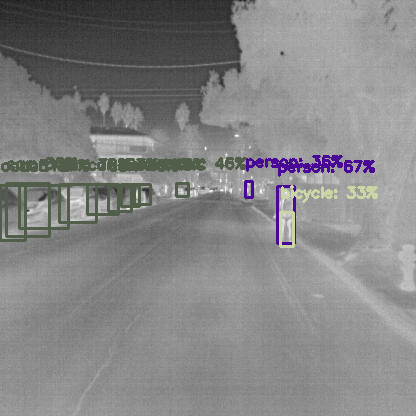

In [ ]:
from PIL import Image
import tensorflow as tf

model_path = 'model.tflite'

INPUT_IMAGE_URL =  "thermal/dataset_1842/test/FLIR_07490_jpeg.rf.f6f352339b908284a9c739e4af4c329a.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()


# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    INPUT_IMAGE_URL, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)


# 3. Compile with EdgeTPU

In [ ]:
#@title
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

!sudo apt-get update

!sudo apt-get install edgetpu-compiler

In [ ]:
#@title
edgetpu_compiler model.tflite --num_segments=1